##Sample Project


In Computer Vision tasks, convolutional neural network (CNN) is very popular. CNN is used in classification, object detection, semantic segmentation, object localisation and so on. In this notebook, we will examine the inner architecture of a CNN. Our chosen CNN is VGG16

In particular, we try to look at *convolutional filters*  of VGG16. VGG16 has many convolutional layer. Each convolutional layer consists of multiple filters. In general, deeper layers often have more filters. Each filter tries to capture some information about the visual input (e.g. an image).

Shallow layers often look at small features (edges, corners, contours, etc.) and deeper layers often look at big features (face detection --> nose, eye, mouth, etc.)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2 as cv # open cv
# the model only accepts an input image of size (96, 96, 3). Colored images are RGB (red, green, blue)--> 3 channels 
# we use open cv to resize the image to (96, 96, 3)

In [3]:
print('TensorFlow version', tf.__version__)

TensorFlow version 2.8.0


In [4]:
# import the pretrained model
model = tf.keras.applications.vgg16.VGG16(
                        include_top=False,
                        weights='imagenet',
                        input_shape=(96,96,3),
                                        )
                                    
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

In [5]:
type(model)

keras.engine.functional.Functional

In [6]:
def get_submodel(model, layer_name):
    """
    return a truncated version of the model (from input till the layer specified in layer_nam)
    Arguments
        model:      keras.engine.functional.Functional (a model in tf)  
        layer_name: str, name of a layer within the model

    """
    return  tf.keras.models.Model(
        model.input, 
        model.get_layer(layer_name).output,
        )
        
get_submodel(model, 'block1_conv2').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [7]:
def create_random_image(shape=(96,96,3)):
    """
    create a random noisy image with specified shape
    Arguments
        shape:  tuple 
    """
    return tf.random.uniform(shape, minval =0, maxval=255)


def plot_image(image, title='random'):
    """
    Standardise the image to [0, 1] scale and then plot
    """
    scale = tf.math.reduce_max(image) -  tf.math.reduce_min(image)
    image = (image - tf.math.reduce_min(image)) / scale
    plt.imshow(image)
    plt.xticks([]) #set to blank
    plt.yticks([]) #set to blank
    plt.title(title)
    plt.show()



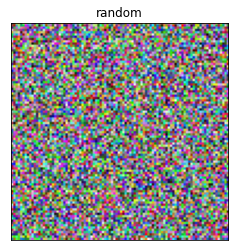

In [8]:
random_image= create_random_image()
plot_image(random_image)

In [9]:
model.output.shape[-1]

512

In [10]:
!pwd

/content


In [15]:
def visualise_filter(model, layer_name, image, filter_index=None, iters=50, learning_rate=10):
    """
    Visualise the filter effect on the image
    Arguments
        model:          model, the full CNN model
        layer_name:     string, name of the convolutional layer
        image:          torch.tensor, the 3D image     
        filter_index:    int, the filter index within multiple filters of the specified layer, default=None
        iters:          int, no. of iterattions, default=50
        learning_rate:  float, default=10
    """
    submodel = get_submodel(model, layer_name)
    num_filters = submodel.output.shape[-1] # number of filters
    filter_index = random.randint(0, num_filters-1) if filter_index is None else filter_index
    assert num_filters > filter_index, 'filter_index is out of bounds'
    verbose_step = iters//10

    for i in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(image)
            out = submodel(tf.expand_dims(image, axis=0))[:,:,:, filter_index] #set batch_size = 1 as the first dim and take only the filter_index position
            loss = tf.math.reduce_mean(out) # approximate the loss
        grads = tape.gradient(loss, image)
        grads = tf.math.l2_normalize(grads) #
        image += grads * learning_rate

        if (i+1)%verbose_step==0:
            print(f'Iteration: {i+1}, Loss: {loss.numpy():.4f}')

    plot_image(image, title=f'{layer_name}, {filter_index}')

In [16]:
print(*[layer.name for layer in  model.layers if 'conv' in layer.name], sep='\t')

block1_conv1	block1_conv2	block2_conv1	block2_conv2	block3_conv1	block3_conv2	block3_conv3	block4_conv1	block4_conv2	block4_conv3	block5_conv1	block5_conv2	block5_conv3


In [17]:
img_lady_path = 'image_lady.jpg' # may need to change the path depending on your Drive
img_street_path = 'image_street.jpg' # may need to change the path depending on your Drive

img_lady = cv.imread(img_lady_path)
img_lady = cv.resize(img_lady, (96,96))
img_lady = tf.convert_to_tensor(img_lady, dtype=tf.float32)
img_lady /= 255

img_street = cv.imread(img_street_path)
img_street = cv.resize(img_street, (96,96))
img_street = tf.convert_to_tensor(img_street, dtype=tf.float32)
img_street /= 255

Iteration: 5, Loss: 6.0888
Iteration: 10, Loss: 12.8975
Iteration: 15, Loss: 19.4401
Iteration: 20, Loss: 26.6814
Iteration: 25, Loss: 33.0141
Iteration: 30, Loss: 39.9814
Iteration: 35, Loss: 47.1848
Iteration: 40, Loss: 54.4191
Iteration: 45, Loss: 59.7755
Iteration: 50, Loss: 69.2504


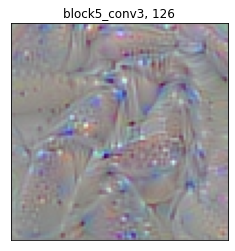

In [21]:
layer_name = 'block5_conv3'
visualise_filter(model, layer_name, img_lady, filter_index=126
                )

Iteration: 5, Loss: 4.1788
Iteration: 10, Loss: 8.3980
Iteration: 15, Loss: 11.9883
Iteration: 20, Loss: 15.6166
Iteration: 25, Loss: 18.2019
Iteration: 30, Loss: 21.6135
Iteration: 35, Loss: 25.1421
Iteration: 40, Loss: 27.9631
Iteration: 45, Loss: 31.3146
Iteration: 50, Loss: 34.8521


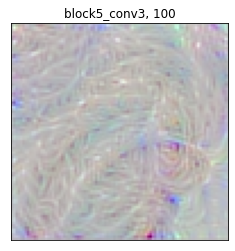

In [26]:
layer_name = 'block5_conv3'
visualise_filter(model, layer_name, img_lady, filter_index=100
                )

Iteration: 5, Loss: 2.8698
Iteration: 10, Loss: 7.2350
Iteration: 15, Loss: 11.0736
Iteration: 20, Loss: 14.9822
Iteration: 25, Loss: 18.7787
Iteration: 30, Loss: 23.2977
Iteration: 35, Loss: 27.7255
Iteration: 40, Loss: 32.4397
Iteration: 45, Loss: 37.3006
Iteration: 50, Loss: 42.5757


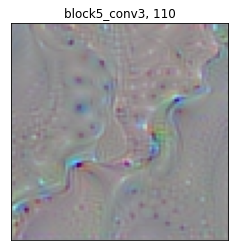

In [27]:
layer_name = 'block5_conv3'
visualise_filter(model, layer_name, img_street, filter_index=110)

Iteration: 5, Loss: 4.3391
Iteration: 10, Loss: 11.0617
Iteration: 15, Loss: 17.3443
Iteration: 20, Loss: 23.2967
Iteration: 25, Loss: 28.4789
Iteration: 30, Loss: 33.9814
Iteration: 35, Loss: 39.5836
Iteration: 40, Loss: 46.2824
Iteration: 45, Loss: 53.0175
Iteration: 50, Loss: 59.6079


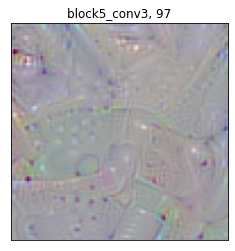

In [32]:
layer_name = 'block5_conv3'
visualise_filter(model, layer_name, img_street, filter_index=97)